# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

 Признаки
  * RowNumber — индекс строки в данных
  * CustomerId — уникальный идентификатор клиента
  * Surname — фамилия
  * CreditScore — кредитный рейтинг
  * Geography — страна проживания
  * Gender — пол
  * Age — возраст
  * Tenure — количество недвижимости у клиента
  * Balance — баланс на счёте
  * NumOfProducts — количество продуктов банка, используемых клиентом
  * HasCrCard — наличие кредитной карты
  * IsActiveMember — активность клиента
  * EstimatedSalary — предполагаемая зарплата

Целевой признак
  * Exited — факт ухода клиента
  
В ходе работы проведем:

* подготовку данных 
* разбивку данных на выборки.
* исследование баланса данных.
* обучение модели без учета баланса.
* улучшение моделей с учетом баланса моделей.
* финальное тестирование модели.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [2]:
data= pd.read_csv(r'C:\Users\mind2\Downloads\Churn.csv', sep=',' , decimal=',') 
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.8,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.0,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.1,0


In [3]:
data.dtypes

RowNumber           int64
CustomerId          int64
Surname            object
CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure             object
Balance            object
NumOfProducts       int64
HasCrCard           int64
IsActiveMember      int64
EstimatedSalary    object
Exited              int64
dtype: object

In [4]:
data.shape

(10000, 14)

Для избежания коллинеарности в данных уберем столбцы 'RowNumber' и 'CustomerId'. Также столбец 'Surname' не является признаком для определения целевого признака. 

In [5]:
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
data.columns = data.columns.str.lower()
data.dtypes

creditscore         int64
geography          object
gender             object
age                 int64
tenure             object
balance            object
numofproducts       int64
hascrcard           int64
isactivemember      int64
estimatedsalary    object
exited              int64
dtype: object

In [6]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Проведем смену типов текстовых данных на числовые данные в столбцах 'tenure', 'balance', 'estimatedsalary'. Для столбца 'tenure' проведем замену пропущенных данных на 0.

In [7]:
def n_type(st,ty):
    data[st] = data[st].astype(ty)


n_type('tenure','float')
data['tenure'] = data['tenure'].fillna(0)
n_type('tenure','uint16')
n_type('balance','float')
n_type('estimatedsalary','float')
data.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure              uint16
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

In [8]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [9]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

Проведем подготовку данных для избежания ловушки фиктивных признаков:

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.dtypes

creditscore            int64
age                    int64
tenure                uint16
balance              float64
numofproducts          int64
hascrcard              int64
isactivemember         int64
estimatedsalary      float64
exited                 int64
geography_Germany      uint8
geography_Spain        uint8
gender_Male            uint8
dtype: object

In [11]:
data_ohe.shape

(10000, 12)

Проведем разделение признаков:

In [12]:
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']

Разобьем датасеты "features" и "target" на тренировочную выборку (60 % объектов) и проверочную выборку (40% объектов). Также разделим проверочную выборку **пополам** на "валидационную" и "тестовую".

In [13]:
features_train, features_tes, target_train, target_tes = train_test_split(features, target, test_size=0.4, 
                                                                          train_size=0.6, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_tes, target_tes, test_size=0.5, 
                                                                            train_size=0.5, random_state=12345)

In [14]:
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(6000, 11)

(6000,)

(2000, 11)

(2000,)

(2000, 11)

(2000,)

In [15]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,567,35,8,153137.74,1,1,0,88659.07,0,1,1
3411,711,37,8,113899.92,1,0,0,80215.20,0,0,0
6027,850,44,3,140393.65,2,0,1,186285.52,1,0,1
1247,512,24,6,0.00,2,1,0,37654.31,0,0,1
3716,665,27,2,147435.96,1,0,0,187508.06,1,0,0


Датасет представляет из себя набор числовых данных с разным форматом. Проведем масштабирование данных:

In [16]:
numeric = ['creditscore', 'age', 'tenure', 'balance','estimatedsalary']
pd.options.mode.chained_assignment = None

In [17]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

features_valid[numeric] = scaler.transform(features_valid[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

In [18]:
features_train.head(20)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,1,0,0,1.524268,1,0,0
8741,-0.315586,-1.512032,1.104696,-1.233163,2,1,1,0.552345,0,1,0
7461,-0.585591,-0.657902,-0.182016,-1.233163,2,0,1,0.814122,0,1,1
5106,-0.544052,-0.657902,-1.147051,0.031212,1,1,0,-0.608723,0,0,0
6130,-0.211738,-0.373192,-0.825373,1.190787,2,0,0,-0.602263,1,0,0
4955,1.273291,-0.562998,-1.468729,0.111168,2,1,0,0.508214,1,0,1


### Вывод:

1. Для избежания коллинеарности в данных убрали столбцы 'RowNumber' и 'CustomerId'. Также столбец 'Surname' не является признаком для определения целевого признака.
2. Провели смену типов текстовых данных на числовые данные в столбцах 'tenure', 'balance', 'estimatedsalary'. Для столбца 'tenure' провели замену пропущенных данных на 0.
3. Провели подготовку данных для избежания ловушки фиктивных признаков.
4. Провели разделение признаков.
5. Разбили датасет на 6 выборок, включающими признаки и целевой признак объекта, с тренировочными, валидационными и тестовыми выборками. В итоге, тренировочная выборка составила 60% исходного датасета, валидационная выборка составила 20% исходного датасета и тестовая выборка составила 20% исходного датасета.
6. Провели масштабирование данных.

## Исследование задачи

Исследуем баланс классов в данных:

0    0.800667
1    0.199333
Name: exited, dtype: float64

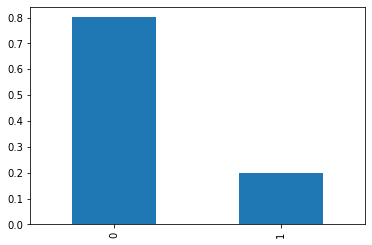

In [19]:
class_freq = target_train.value_counts(normalize=True)
display(class_freq)
class_freq.plot(kind='bar')
plt.show()

Данные целевого признака сильно смещены в сторону значения '0'. 80 % - 0 против 20% - 1.

Изучим модель решающего дерева и выведем параметры и метрику F-1 наилучшей модели без учета баланса данных:

In [20]:
best_model_1 = None
best_result = 0
for depth in range(2,20,1):
    for leaf in range(1,15,1):
        model_1 = DecisionTreeClassifier(max_depth=depth, random_state=12345, min_samples_leaf=leaf)
        model_1.fit(features_train, target_train)
        predictions_valid = model_1.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_1 = model_1
            best_result = result
display("Параметры наилучшей модели решающего дерева:", best_model_1)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели решающего дерева:'

DecisionTreeClassifier(max_depth=9, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.5786516853932585

array([0.05462649, 0.32543929, 0.02286862, 0.11485542, 0.22430207,
       0.00906426, 0.12321368, 0.04877762, 0.05588361, 0.00438261,
       0.01658634])

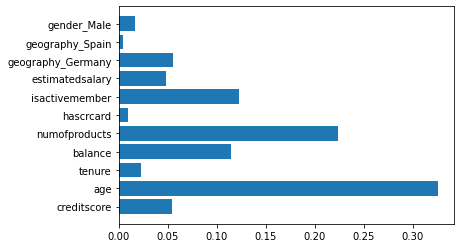

In [21]:
display(model_1.feature_importances_)
plt.barh(features.columns, model_1.feature_importances_)
plt.show()

Изучим модель случайного леса и выведем параметры и метрику F-1 наилучшей модели без учета баланса данных:

In [22]:
%%time
best_model_2 = None
best_result = 0
for est in range(1, 41, 1):
    for depth in range(2, 20, 1):
        model_2 = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model_2.fit(features_train,target_train)
        predicted_valid = model_2.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model_2 = model_2
            best_result = result
display("Параметры наилучшей модели случайного леса:", best_model_2)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели случайного леса:'

RandomForestClassifier(max_depth=19, n_estimators=27, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.6052631578947368

Wall time: 3min 39s


array([0.1417638 , 0.23710444, 0.08197105, 0.14086672, 0.12533199,
       0.02030613, 0.04382117, 0.14203644, 0.03332829, 0.01282771,
       0.02064226])

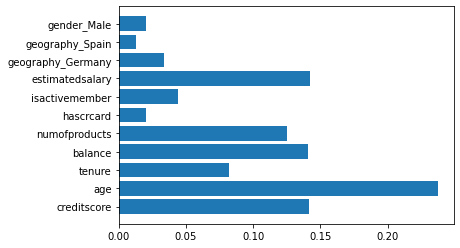

In [23]:
display(model_2.feature_importances_)
plt.barh(features.columns, model_2.feature_importances_)
plt.show()

Изучим модель логистической регрессии и выведем метрику F-1 без учета баланса данных:

In [24]:
warnings.filterwarnings("ignore")
model_3 = LogisticRegression(random_state=12345)
model_3.fit(features_train, target_train)
predictions_valid = model_3.predict(features_valid)
result = f1_score(target_valid, predictions_valid)

display("Метрика F-1 логистической регрессии:", result)

'Метрика F-1 логистической регрессии:'

0.33389544688026984

In [25]:
features.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'geography_Germany',
       'geography_Spain', 'gender_Male'],
      dtype='object')

array([[-0.08546321,  0.78569859, -0.05621322,  0.18100134, -0.02646664,
        -0.21925249, -1.14883767,  0.03743385,  0.89243749,  0.13216217,
        -0.5893071 ]])

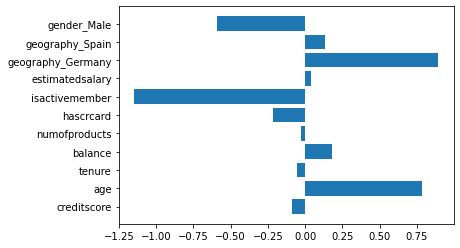

In [26]:
display(model_3.coef_)
model_3.coef=pd.DataFrame(model_3.coef_)
plt.barh(features.columns, model_3.coef.iloc[0,:])
plt.show()

### Вывод

1. Провели исследование балансов данных. В данных целевого признака баланс сильно смещен в сторону значений 0 (80% против 20%).
2. Провели исследование модели решающего дерева без учета баланса данных. Получили метрику F-1 наилучшей модели -0.57865.
3. Провели исследование модели случайного леса без учета баланса данных. Получили метрику F-1 наилучшей модели - 0.60526.
4. Провели исследование модели логистической регрессии без учета баланса данных. Получили метрику F-1 - 0,333895.

## Борьба с дисбалансом

Проведем улучшение обучение моделей с учетом баланса классов.

1. Установим при обучении моделей параметр 'class_weight='balanced''

Изучим модель логистической регрессии и выведем метрику F-1 с учетом баланса данных:

In [27]:
model_3 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_3.fit(features_train, target_train)
predictions_valid = model_3.predict(features_valid)
result = f1_score(target_valid, predictions_valid)

display("Метрика F-1 логистической регрессии:", result)

'Метрика F-1 логистической регрессии:'

0.4888888888888888

Изучим модель случайного леса и выведем параметры и метрику F-1 наилучшей модели с учетом баланса данных:

In [28]:
best_model_2 = None
best_result = 0
for est in range(1, 41, 1):
    for depth in range(2, 20, 1):
        model_2 = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model_2.fit(features_train,target_train)
        predicted_valid = model_2.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model_2 = model_2
            best_result = result 
display("Параметры наилучшей модели случайного леса:", best_model_2)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели случайного леса:'

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=40,
                       random_state=12345)

'Метрика F-1 наилучшей модели:'

0.6276595744680851

Изучим модель решающего дерева и выведем параметры и метрику F-1 наилучшей модели с учетом баланса данных:

In [29]:
best_model_1 = None
best_result = 0
for depth in range(2,20,1):
    for leaf in range(1,15,1):
        model_1 = DecisionTreeClassifier(max_depth=depth, random_state=12345, min_samples_leaf=leaf, class_weight='balanced')
        model_1.fit(features_train, target_train)
        predictions_valid = model_1.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_1 = model_1
            best_result = result
display("Параметры наилучшей модели решающего дерева:", best_model_1)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели решающего дерева:'

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.6010471204188481

2. Применим метод 'upsample', т. е. добавление данных к наименьшему класса, тем самым выравнивая баланс.

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

Изучим модель логистической регрессии и выведем метрику F-1 с учетом баланса данных:

In [31]:
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(features_upsampled, target_upsampled)
predictions_valid = model_3.predict(features_valid)
result = f1_score(target_valid, predictions_valid)

display("Метрика F-1 логистической регрессии:", result)

'Метрика F-1 логистической регрессии:'

0.419889502762431

Изучим модель случайного леса и выведем параметры и метрику F-1 наилучшей модели с учетом баланса данных:

In [32]:
best_model_2 = None
best_result = 0
for est in range(1, 41, 1):
    for depth in range(2, 20, 1):
        model_2 = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model_2.fit(features_upsampled, target_upsampled)
        predicted_valid = model_2.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model_2 = model_2
            best_result = result
display("Параметры наилучшей модели случайного леса:", best_model_2)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели случайного леса:'

RandomForestClassifier(max_depth=16, n_estimators=28, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.6106304079110012

Изучим модель решающего дерева и выведем параметры и метрику F-1 наилучшей модели с учетом баланса данных:

In [33]:
best_model_1 = None
best_result = 0
for depth in range(2,20,1):
    for leaf in range(1,15,1):
        model_1 = DecisionTreeClassifier(max_depth=depth, random_state=12345, min_samples_leaf=leaf)
        model_1.fit(features_upsampled, target_upsampled)
        predictions_valid = model_1.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_1 = model_1
            best_result = result
display("Параметры наилучшей модели решающего дерева:", best_model_1)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели решающего дерева:'

DecisionTreeClassifier(max_depth=17, min_samples_leaf=7, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.534466477809254

3. Применим метод 'downsample', т. е. убавление данных из большего класса, тем самым выравнивая баланс.

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

Изучим модель логистической регрессии и выведем метрику F-1 с учетом баланса данных:

In [35]:
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(features_downsampled, target_downsampled)
predictions_valid = model_3.predict(features_valid)
result = f1_score(target_valid, predictions_valid)

display("Метрика F-1 логистической регрессии:", result)

'Метрика F-1 логистической регрессии:'

0.4296212549462973

Изучим модель случайного леса и выведем параметры и метрику F-1 наилучшей модели с учетом баланса данных:

In [36]:
best_model_2 = None
best_result = 0
for est in range(1, 41, 1):
    for depth in range(2, 20, 1):
        model_2 = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model_2.fit(features_downsampled, target_downsampled)
        predicted_valid = model_2.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model_2 = model_2
            best_result = result 
display("Параметры наилучшей модели случайного леса:", best_model_2)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели случайного леса:'

RandomForestClassifier(max_depth=19, n_estimators=6, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.49565217391304356

Изучим модель решающего дерева и выведем параметры и метрику F-1 наилучшей модели с учетом баланса данных:

In [37]:
best_model_1 = None
best_result = 0
for depth in range(2,20,1):
    for leaf in range(1,15,1):
        model_1 = DecisionTreeClassifier(max_depth=depth, random_state=12345, min_samples_leaf=leaf)
        model_1.fit(features_downsampled, target_downsampled)
        predictions_valid = model_1.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_1 = model_1
            best_result = result
display("Параметры наилучшей модели решающего дерева:", best_model_1)
display("Метрика F-1 наилучшей модели:", best_result)

'Параметры наилучшей модели решающего дерева:'

DecisionTreeClassifier(max_depth=6, min_samples_leaf=12, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.5084249084249084

4. Исправим баланс путем изменения порога ('threshold'). Выведем метрики параметров F-1 и auc_roc (площадь под кривой ошибок).  

Изучим модель логистической регрессии:

In [38]:
best_result = 0
best_threshold = 0
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(features_train, target_train)
probabilities_valid = model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.98, 0.02):
    predicted_valid = model_3.predict(features_valid)
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > best_result:
        best_result = f1
        best_threshold = threshold
display("Метрика F-1 наилучшей модели:", best_result)
display("Значение параметра 'threshold' наилучшей модели:", best_threshold)
display("Значение параметра 'auc_roc' наилучшей модели:", auc_roc)

'Метрика F-1 наилучшей модели:'

0.5

"Значение параметра 'threshold' наилучшей модели:"

0.26

"Значение параметра 'auc_roc' наилучшей модели:"

0.7585879420998192

Изучим модель решающего дерева:

In [39]:
best_model = None
best_result = 0
best_threshold = 0
for depth in range(3,20,1):
    for leaf in range(1,15,1):
        model_1 = DecisionTreeClassifier(max_depth=depth, random_state=12345, min_samples_leaf=leaf)
        model_1.fit(features_train, target_train)
        probabilities_valid = model_1.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        for threshold in np.arange(0, 0.98, 0.02):
            predicted_valid = model_1.predict(features_valid)
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_valid, predicted_valid)
            if f1 > best_result:
                best_model = model_1
                best_result = f1
                best_threshold = threshold
display("Параметры наилучшей модели решающего дерева:", best_model_1)
display("Метрика F-1 наилучшей модели:", best_result)
display("Значение параметра 'threshold' наилучшей модели:", best_threshold)
display("Значение параметра 'auc_roc' наилучшей модели:", auc_roc)

'Параметры наилучшей модели решающего дерева:'

DecisionTreeClassifier(max_depth=6, min_samples_leaf=12, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.6100861008610087

"Значение параметра 'threshold' наилучшей модели:"

0.26

"Значение параметра 'auc_roc' наилучшей модели:"

0.8034307913790913

Изучим модель случайного леса:

In [40]:
best_model_2 = None
best_result = 0
best_threshold = 0
for est in range(1, 41, 1):
    for depth in range(1, 20, 1):
        model_2 = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model_2.fit(features_train, target_train)
        probabilities_valid = model_2.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        for threshold in np.arange(0, 0.68, 0.02):
            predicted_valid = model_2.predict(features_valid)
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_model_2 = model_2
                best_result = f1
                best_threshold = threshold 
display("Параметры наилучшей модели случайного леса:", best_model_2)
display("Метрика F-1 наилучшей модели:", best_result)
display("Значение параметра 'threshold' наилучшей модели:", best_threshold)
display("Значение параметра 'auc_roc' наилучшей модели:", auc_roc)

'Параметры наилучшей модели случайного леса:'

RandomForestClassifier(max_depth=4, n_estimators=1, random_state=12345)

'Метрика F-1 наилучшей модели:'

0.519036519036519

"Значение параметра 'threshold' наилучшей модели:"

0.1

"Значение параметра 'auc_roc' наилучшей модели:"

0.839012001040413

### Вывод

Провели улучшение обучение моделей с учетом баланса классов:
1. Установили при обучении моделей параметр 'class_weight='balanced'':
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0.60105.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.62708.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 - 0,488889.
2. Применили метод 'upsample', т. е. добавление данных к наименьшему класса, тем самым выравнивая баланс:
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0,53447.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.61063.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 - 0,41989.
3. Применили метод 'downsample', т. е. убавление данных из большего класса, тем самым выравнивая баланс:
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0.505425.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.49565.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 - 0,42962.
4. Исправим баланс путем изменения порога ('threshold'): Выведем метрики параметров F-1 и auc_roc (площадь под кривой ошибок).
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0.610086, auc_roc - 0.803431.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.519037  , auc_roc - 0.839012.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 наилучшей модели - 0.5 , auc_roc - 0.758588.

## Тестирование модели

Проведем тестирование модели с наибольшим параметром метрики F-1:

In [41]:
model_2 = RandomForestClassifier(n_estimators=36, max_depth=10, random_state=12345, class_weight='balanced')
model_2.fit(features_upsampled, target_upsampled)
predicted_test = model_2.predict(features_test)
result = f1_score(target_test, predicted_test)
probabilities_valid = model_2.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)

display("Метрика F-1:", result)
display("Значение параметра 'auc_roc':", auc_roc)

'Метрика F-1:'

0.6042553191489363

"Значение параметра 'auc_roc':"

0.8547148654341142

## Вывод

Провели обработку данных:
1. Провели подготовку данных для избежания ловушки фиктивных признаков.
2. Разбили датасет на 6 выборок, включающими признаки и целевой признак объекта, с тренировочными, валидационными и тестовыми выборками. В итоге, тренировочная выборка составила 60% исходного датасета, валидационная выборка составила 20% исходного датасета и тестовая выборка составила 20% исходного датасета.
3. Провели масштабирование данных.

Провели исследование балансов данных. 
1. В данных целевого признака баланс сильно смещен в сторону значений 0 (80% против 20%).
2. Провели исследование модели решающего дерева без учета баланса данных. Получили метрику F-1 наилучшей модели -0.57865.
3. Провели исследование модели случайного леса без учета баланса данных. Получили метрику F-1 наилучшей модели - 0.60526.
4. Провели исследование модели логистической регрессии без учета баланса данных. Получили метрику F-1 - 0,333895.

Провели улучшение обучение моделей с учетом баланса классов:
1. Установили при обучении моделей параметр 'class_weight='balanced'':
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0.60105.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.62708.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 - 0,488889.
2. Применили метод 'upsample', т. е. добавление данных к наименьшему класса, тем самым выравнивая баланс:
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0,53447.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.61063.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 - 0,41989.
3. Применили метод 'downsample', т. е. убавление данных из большего класса, тем самым выравнивая баланс:
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0.505425.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.49565.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 - 0,42962.
4. Исправим баланс путем изменения порога ('threshold'): Выведем метрики параметров F-1 и auc_roc (площадь под кривой ошибок).
  - Провели исследование модели решающего дерева. Получили метрику F-1 наилучшей модели - 0.610086, auc_roc - 0.803431.
  - Провели исследование модели случайного леса. Получили метрику F-1 наилучшей модели - 0.519037  , auc_roc - 0.839012.
  - Провели исследование модели логистической регрессии. Получили метрику F-1 наилучшей модели - 0.5 , auc_roc - 0.758588.

Провели тестирование модели с наибольшим параметром метрики F-1. Получили следующие результаты: 
- метрика F-1: 0.61199
- метрика auc_roc: 0.85531